In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import os
import csv
import seaborn as sns
%matplotlib inline

# The statistical module used to run chi square test
import scipy.stats as stats

In [3]:
#Read csv
general_df = pd.read_csv('final_zillow_info.csv').dropna() #dropping NAN from all the data in the table
general_df.head()
print(len(general_df))

7319


In [4]:
condo_df = general_df.loc[general_df['Home Type']=='Condominium'] #creates a df for 'Condo' only

In [5]:
# CHANGE COLUMN NAME
condo_final_df = condo_df.rename(columns={"Tax_Year":"Tax Year","Last Sold Date":"Sold Date","Last Sold Price":"Sold Price",
                                    "Zestimate Amount": "Current Estimated Value",
                                    "Zestimate Date":"Estimated Date",
                                    "Zestimate Value Change":"Estimated Value Change"})
condo_final_df.head()

,Address,Zip,Zillow ID,Tax,Tax Year,Home Type,Home Size,Bathrooms,Bedrooms,Sold Date,Sold Price,Current Estimated Value,Estimated Date,Estimated Value Change
0,5 14th,60605,60204228.0,248760.0,2017.0,Condominium,10593.0,2.0,2.0,05/27/2004,295000.0,395223.0,04/03/2019,48923.0
8,23 E 13th St 606,60605,70474983.0,513000.0,2017.0,Condominium,78844.0,2.0,2.0,07/20/2012,525000.0,657483.0,04/03/2019,-597.0
9,125 E 13th St,60605,70474811.0,490400.0,2017.0,Condominium,23332.0,2.0,2.0,04/17/2013,565000.0,645588.0,04/03/2019,-24410.0
11,125 E 13th St 1002,60605,70474919.0,28050.0,2017.0,Condominium,23332.0,2.0,2.0,06/12/2017,433000.0,36498.0,04/03/2019,96.0
12,125 E 13th St 1003,60605,70474751.0,321140.0,2017.0,Condominium,23332.0,2.0,2.0,06/12/2017,433000.0,410062.0,04/03/2019,14320.0


In [9]:
#1, 2 and 3 bedrooms dataframe
one_bedroom_df = condo_final_df[condo_final_df["Bedrooms"] == 1.0]
two_bedrooms_df = condo_final_df[condo_final_df["Bedrooms"] == 2.0]
three_bedrooms_df = condo_final_df[condo_final_df["Bedrooms"] == 3.0]

In [14]:
#Bedrooms dataframes combined
frames = [one_bedroom_df, two_bedrooms_df, three_bedrooms_df]
bedrooms_combined_df = pd.concat(frames)
bedrooms_combined_df.head()
print(len(bedrooms_combined_df))

5399


Bedrooms
1.0    2021
2.0    2599
3.0     779
Name: Zillow ID, dtype: int64


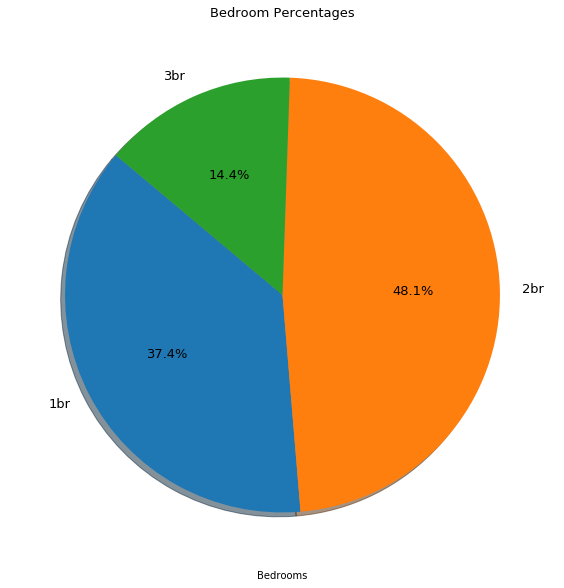

In [15]:
bedrooms_count = bedrooms_combined_df.groupby(["Bedrooms"]).count()["Zillow ID"]
print(bedrooms_count)

#Bedrooms Pie Chart
plt.pie(bedrooms_count,
        labels=["1br", "2br", "3br"],
        autopct='%.1f%%', shadow=True, startangle=140,
        textprops={"fontsize": 13}) # re-sizes fonts size
plt.title("Bedroom Percentages", fontsize=13)

#Re-sizes plot pie
bedrooms_count.plot(figsize=(20,10))

#Save image
plt.savefig("Images/bedroomPerc.png")

# Show Figure
plt.show()

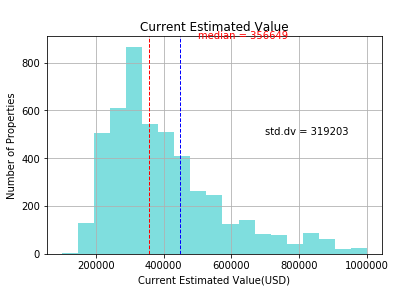

In [16]:
#Histgram 
#Calc mean, median, std dev
mean = bedrooms_combined_df['Current Estimated Value'].mean()
median = bedrooms_combined_df['Current Estimated Value'].median()
std = bedrooms_combined_df['Current Estimated Value'].std()
mean_round = 'mean = ' + str(round(mean))
median_round = 'median = ' + str(round(median))
std_round = 'std.dv = ' + str(round(std))

condo_df_hist_amount = bedrooms_combined_df.drop([0]).hist(['Current Estimated Value'],range=(100000,1000000),bins=19,alpha=0.5,color='c')
plt.axvline(mean, color='b', linestyle='dashed', linewidth=1, )
plt.axvline(median, color='r', linestyle='dashed', linewidth=1)
plt.annotate(mean_round,xy=(500000,1000),color='b')
plt.annotate(median_round,xy=(500000,900),color='r')
plt.annotate(std_round,xy=(700000,500),color='k')
plt.xlabel('Current Estimated Value(USD)')
plt.ylabel('Number of Properties')
plt.title('Current Estimated Value')
plt.savefig("Images/histogram1.png")

In [17]:
#Clean data for Increase% Histgram
bedrooms_combined_df['Amount 30days before'] = bedrooms_combined_df['Current Estimated Value']-bedrooms_combined_df['Estimated Value Change']
bedrooms_combined_df['Increase% for 30days'] = bedrooms_combined_df['Estimated Value Change']/bedrooms_combined_df['Amount 30days before']

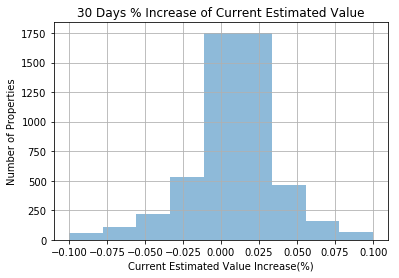

In [18]:
# Show Increase% Histgram
condo_df_hist_increase = bedrooms_combined_df.drop([0]).hist(['Increase% for 30days'],range=(-0.1,0.1),bins=9,alpha=0.5)
plt.xlabel('Current Estimated Value Increase(%)')
plt.ylabel('Number of Properties')
plt.title('30 Days % Increase of Current Estimated Value')
plt.savefig("Images/histogram2.png")
#plt.show()

/anaconda2/envs/PythonData/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


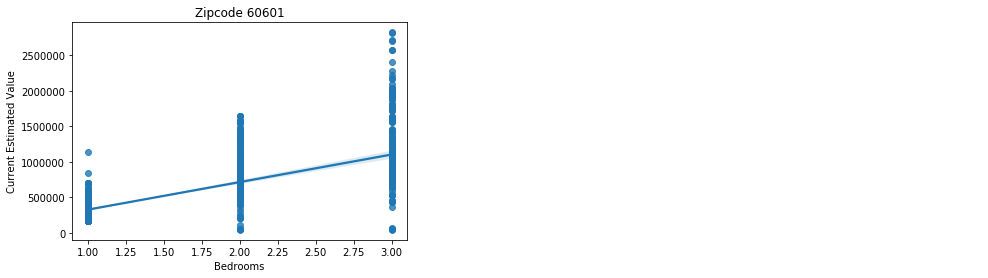

In [19]:
# Calc correlation between Zestimate amount vs Bedrooms
condo_df_zip1 = bedrooms_combined_df.loc[general_df['Zip']==60601]

# Calc r
r = np.corrcoef (condo_df_zip1['Bedrooms'], condo_df_zip1['Current Estimated Value'])[1,0]
r_round = 'r =' + str(r.round(4))

# Calc Linear function
myXset = np.array(condo_df_zip1['Bedrooms'])
myYset = np.array(condo_df_zip1['Current Estimated Value'])
coefficient = np.polyfit(myXset, myYset, 1)
Y_func = np.poly1d(coefficient)
linear = 'y = ' + str(coefficient[0].round(0)) + 'X + ' + str(coefficient[1].round())
linear

# Show scatter
sns.regplot(x='Bedrooms',y='Current Estimated Value',data=condo_df_zip1,truncate=True)
plt.annotate(linear,xy=(6,2250000))
plt.annotate(r_round,xy=(6,2000000))

plt.title('Zipcode 60601')
plt.savefig("Images/scatter60601.png")

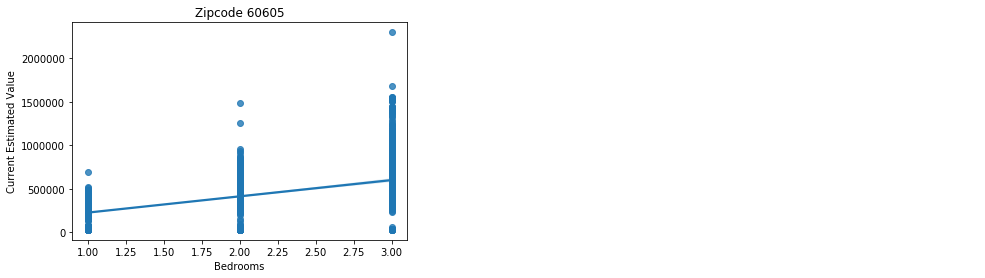

In [25]:
# Calc correlation between Zestimate amount vs Bedrooms
condo_df_zip2 = bedrooms_combined_df.loc[general_df['Zip']==60605]

# Calc r
r = np.corrcoef (condo_df_zip2['Bedrooms'], condo_df_zip2['Current Estimated Value'])[1,0]
r_round = 'r =' + str(r.round(4))

# Calc Linear function
myXset = np.array(condo_df_zip2['Bedrooms'])
myYset = np.array(condo_df_zip2['Current Estimated Value'])
coefficient = np.polyfit(myXset, myYset, 1)
Y_func = np.poly1d(coefficient)
linear = 'y = ' + str(coefficient[0].round(0)) + 'X + ' + str(coefficient[1].round())
linear

# Show scatter
sns.regplot(x='Bedrooms',y='Current Estimated Value',data=condo_df_zip2,truncate=True)
plt.annotate(linear,xy=(6,2250000))
plt.annotate(r_round,xy=(6,2000000))

plt.title('Zipcode 60605')
plt.savefig("Images/scatter60605.png")

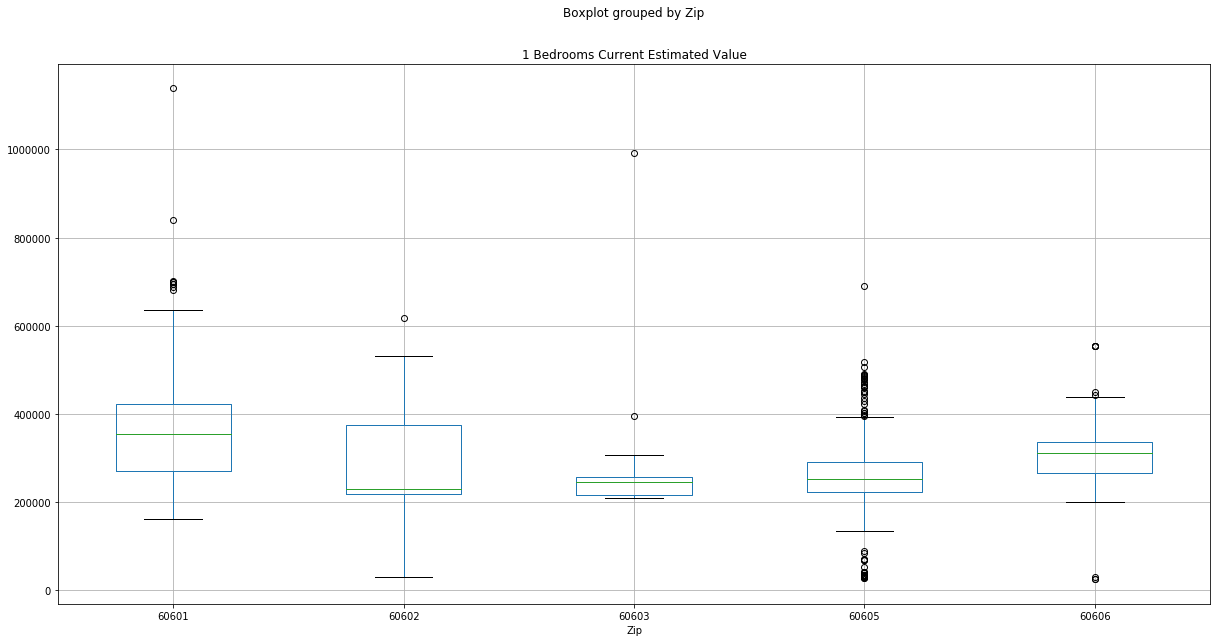

In [27]:
# only focus on 1bed to see the variance of amount by zip
one_bedroom_df.boxplot('Current Estimated Value',by="Zip",figsize=(20, 10))
plt.title('1 Bedrooms Current Estimated Value')
plt.savefig("Images/boxplot1br.png")

In [28]:
# only focus on 2bed to see the variance of amount by zip
two_bedroom_df.boxplot('Current Estimated Value',by="Zip",figsize=(20, 10))
plt.title('2 Bedrooms Current Estimated Value')
plt.savefig("Images/boxplot2br.png")

NameError: name 'two_bedroom_df' is not defined

# Chi-square Caulculations

In [21]:

one_br = bedrooms_combined_df.loc[bedrooms_combined_df['Bedrooms']==1]
one_br_count = len(one_br)

two_br = bedrooms_combined_df.loc[bedrooms_combined_df['Bedrooms']==2]
two_br_count = len(two_br)

three_br = bedrooms_combined_df.loc[bedrooms_combined_df['Bedrooms']==3]
three_br_count = len(three_br)

# Observed data in a (hypothetical) number of 5399 properties
observed = pd.Series([one_br_count, two_br_count, three_br_count], index=["1br", "2br", "3br"])

# Create a data frame
df = pd.DataFrame([observed]).T

# Add a column whose default values are the expected values
df[1] = 1799.66

# Rename the columns
df.columns = ["observed", "expected"]

# View the data frame
df

,observed,expected
1br,2021,1799.66
2br,2599,1799.66
3br,779,1799.66


In [22]:
# With four rows, the degree of freedom is 3-1 = 2
# With a p-value of 0.05, the confidence level is 1.00-0.05 = 0.95.
critical_value = stats.chi2.ppf(q = 0.95, df = 2)

In [23]:
# The critical value
critical_value

5.991464547107979

In [24]:
# Run the chi square test with stats.chisquare()
stats.chisquare(df['observed'], df['expected'])

Power_divergenceResult(statistic=961.1163590900503, pvalue=1.9780369049383863e-209)

### Pvalue definition: 
In the majority of analyses, an alpha of 0.05 is used as the cutoff for significance. If the p-value is less than 0.05, we reject the null hypothesis that there's no difference between the means and conclude that a significant difference does exist

In [150]:
# Calculate the Taska
one_br.Tax.mean()
two_br.Tax.mean()
three_br.Tax.mean()

562736.7907573812

In [154]:
# Calculate Independent (Two Sample) T-Test -> 1 and 2 bedrooms
stats.ttest_ind(one_br.Tax, two_br.Tax, equal_var=False)

Ttest_indResult(statistic=-26.698675682036576, pvalue=4.337649601805313e-145)

In [152]:
# Calculate Independent (Two Sample) T-Test -> 1 and 3 bedrooms
stats.ttest_ind(one_br.Tax, three_br.Tax,equal_var=False)

Ttest_indResult(statistic=-27.653781377759532, pvalue=1.9254712632034193e-119)

In [143]:
# Calculate Independent (Two Sample) T-Test -> 2 and 3 bedrooms
stats.ttest_ind(two_br.Tax, three_br.Tax,equal_var=False)

Ttest_indResult(statistic=-18.99535950593644, pvalue=8.034261859373141e-68)